### CIR Model to simulate changes in Interest Rates and Liabilities Hedging

The Cox, Ingersoll & Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates:
$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t}dW_t$$

In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms, get_ind30_size, plot_ef2
import ipywidgets as widgets
from IPython.display import display

pd.options.display.float_format = '{:.6f}'.format

In [2]:
m = Metrics()

Interest rates change over time and they have an enormous impact on the funding ratio. Therefore it is essential to model them in order to understand how our portfolio evolves over time.

In [3]:
# short rate vs annualized
yearly_int_rate =1
debt= 1 + 1*1
debt

2

In [4]:
# twice per year
1 + 1*0.5 + (1 + 1*0.5)*0.5

2.25

In [5]:
# four times per year
1 +  1*0.25 + (1 +  1*0.25)*0.25 + (1 +  1*0.25 + (1 +  1*0.25)*0.25)*0.25 +\
(1 +  1*0.25 + (1 +  1*0.25)*0.25 + (1 +  1*0.25 + (1 +  1*0.25)*0.25)*0.25)*0.25

2.44140625

In general if we compound every 1/N per year (i.e. N times a year),
with r being the yearly interest rate we get:

$$\left(1+\frac{r}{N}\right)^N$$


In [6]:
(1+1/2)**2

2.25

In [7]:
(1+1/100)**100

2.7048138294215285

In [8]:
# e number (for N very large)
(1+1/10000)**10000

2.7181459268249255

Annual Rate vs Instantaneous (or Short) Rate relationship:

$$ r_{inst} = ln(1+r_{annual}) $$

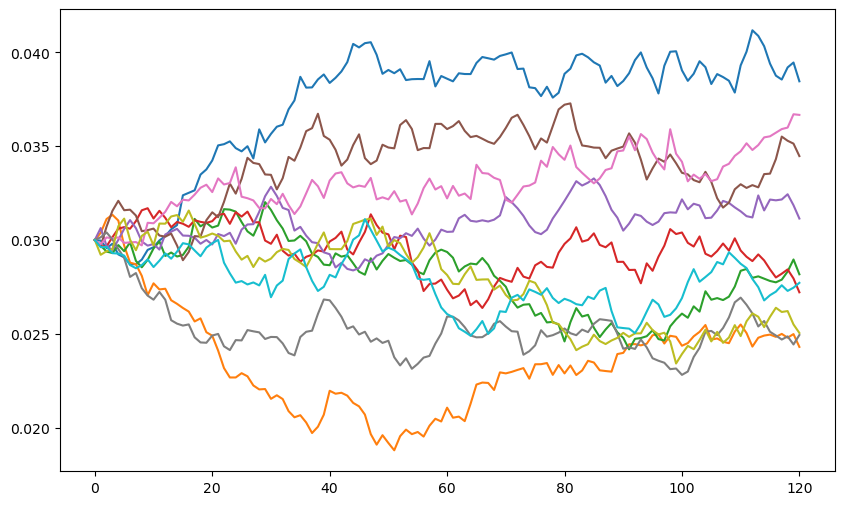

In [9]:
m.cir(n_scenarios=10, sigma=0.01)[0].plot(legend=False);

In [10]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    m.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[0].plot(legend=False)

In [11]:
controls = widgets.interactive(show_cir,
                               r_0 = (0, .15, .01),
                               a = (0, 1,.1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100)
)
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

OBJECTIVE: Let's figure out what happens to the price of the Zero Coupon Bond (we were using as a hedge) when Interest Rates change

The CIR model can also be used to generate the movement of of bond prices for a zero coupon that are implied by the generated interest rate, using the following equation:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [14]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    m.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False)

In [15]:
controls = widgets.interactive(show_cir_prices,
                               r_0 = (0, .15, .01),
                               a = (0, 1,.1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100)
)
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

COMMENT: this is the evolution in Price of a Zero Coupon Bond (ZCB). As interests go up the price of ZCB goes down.
As interesta rates go down the price of Bond goes up. The price of the Bond no matter what parameter you change will eventually converge to 1 at maturity date.
Along the way there could be a lot of variation

We built a model that change interest rates and how a ZCB price change. Now we are able to compare an hedge done with
a ZCB w.r.t. using cash as hedge.